In [1]:
%matplotlib notebook

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data
from torchvision.utils import make_grid
import torch.nn as nn
from time import time as time
import cv2

import PIL

import numpy as np
from matplotlib import pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [52]:
dataroot = "./Data/specs/"

image_size = 64
workers = 2
batch_size = 64

num_epochs = 150
lr = 0.0002
beta1 = 0.5

Maybe get rid of padding somehow???

In [68]:
dataset = torchvision.datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               torchvision.transforms.Pad((0, 0, 54, 54)),
                               transforms.ToTensor(),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

<IPython.core.display.Javascript object>


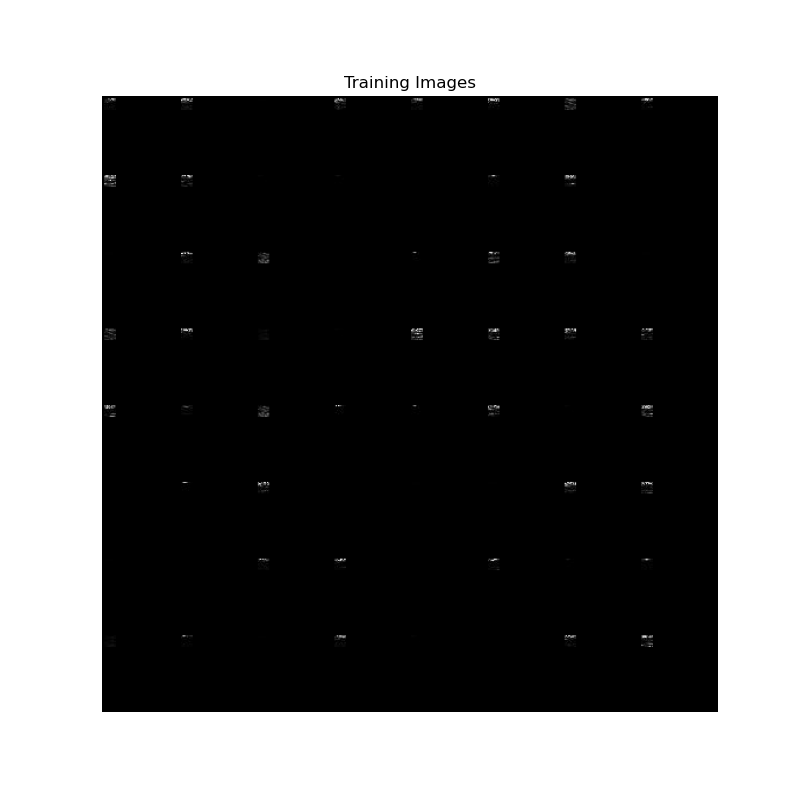

In [69]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Generator
Suggestions: maybe write a custom zeroing layer (to get rid of problems with generating zero padding, which leads to a complete domination of D at the beginning)??? <br>

Principle (WARNING: THE LAST TERM MAYBE CAN BE OMITTED, LOOK AT TRAINING PROGRESS): <br>

$$\mathcal{L}'_G = \mathcal{L}_G + \lambda_1*\mu(|I_{E} - G(E)|) + \lambda_2*\mu(|G(X)|_{paddedpart}),$$ <br>
where <br>
$\mu(X)$ represents elements mean for tensor $X$ (scalar value),<br>
$I_E$ is a batch of images corresponding to a set of edfs $E$ (subtraction and abs. are element-wise here),<br>
$G(E)$ is a result of generating a batch of images from edfs as inputs (those edfs for which we know the specs), <br>
$X_{paddedpart}$ means that we take everything except 10x10 part in upper-left of our images, <br>
$\lambda_1$ and $\lambda_2$ are hyperparameters.<br>


The first term is the original loss.<br>
The second term is a penalty for generating spectrums too different from originals (we know that some specs correspond to definite edfs) <br>
The third term is a penalty for generating non-zeros in a "padded area" (everything except 10x10 square) <br>

Why MAE, not MSE? Because we're working with numbers with absolute values $\leq 1$ and these numbers can be very-very small. MSE can lead to numerical unstability.

In [159]:
channels = 1
noise_len = 90
#Maybe add custom zeroing layer
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_len , 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64 * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 1, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [160]:
netG = Generator().to(device)
netG.apply(weights_init)
netG

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(90, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [161]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels, 64 * 1, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 1, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [162]:
netD = Discriminator().to(device)
netD.apply(weights_init)
netD

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [163]:
#returns a bunch of pairs: edf piece - image (its spec)
class penalty_1_helper():
    def __init__(self, path, delim = ";", img_size = 64):
        self.dataset = np.loadtxt(path, delimiter = delim)
        self.img_size = img_size
        
    def next(self, n):
        idx = np.random.randint(self.dataset.shape[0], size = n)
        random_rows = self.dataset[idx]
        imgs = []
        edfs = []
        for row in random_rows:
            img = row[90:-12].reshape(10, 10)
            img = np.append(img, np.zeros((10, 54)), axis = 1)
            img = np.append(img, np.zeros((54, 64)), axis = 0)
            #print(img.shape)
            imgs.append(img)
            edf = row[:90]
            edfs.append(edf)
            
        return edfs, imgs

In [164]:
#mean deviation from zero in padded zone
def count_penalty_2(fake):
    s = 0
    for img in fake:
        s += torch.mean(torch.abs(img[0][10:-10, :-10]))
        s += torch.mean(torch.abs(img[0][:-10, 10:-10]))
        s += torch.mean(torch.abs(img[0][-10:, -10:]))
        
    return s / len(fake)

In [165]:
criterion = nn.BCELoss()

real_label = 1.
fake_label = 0.

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [167]:
#GAUSSIAN NOISE DOESN't WORK AS WE DON't KNOW IF OUR VARIANCE IS SMALL ENOUGH :(
lmbd_1 = 150 #huge number is recommended
lmbd_2 = 100 #huge number is recommended

helper = penalty_1_helper("./edf_datasets/THE_DATASET.csv")

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        #label smoothing with abs(normal distributed noise) (up to 0.2 from exact unit)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device) - torch.abs(torch.randn(b_size, device=device)/5)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, 90, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        original_loss = criterion(output, label)
        
        #Penalty 1 (term 2, G's penalty for deviation on testing set)
        edfs, imgs = helper.next(len(data[0]))
        input_batch = netG(torch.tensor(edfs).reshape(len(data[0]), 90, 1, 1).type(torch.FloatTensor).cuda())
        penalty_1 = torch.mean(torch.abs(input_batch - torch.tensor(imgs).cuda()))
        
        #Penalty 2 (term 3, G's penalty for non-zeroing padded zone)
        #Maybe can be omitted
        penalty_2 = count_penalty_2(fake)
        
        errG = original_loss + penalty_1 * lmbd_1 + 0

        errG.backward()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tPenalty_1 * lmbd_1: %.4f\tPenalty_2 * lmbd_2: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), penalty_1 * lmbd_1, penalty_2 * lmbd_2))

[0/150][0/346]	Loss_D: 2.1804	Loss_G: 35.0035	Penalty_1 * lmbd_1: 24.9484	Penalty_2 * lmbd_2: 53.9170
[0/150][50/346]	Loss_D: 0.6035	Loss_G: 15.7339	Penalty_1 * lmbd_1: 3.7879	Penalty_2 * lmbd_2: 33.8024
[0/150][100/346]	Loss_D: 0.4702	Loss_G: 11.1859	Penalty_1 * lmbd_1: 3.5171	Penalty_2 * lmbd_2: 21.1172
[0/150][150/346]	Loss_D: 0.4839	Loss_G: 6.8296	Penalty_1 * lmbd_1: 2.7673	Penalty_2 * lmbd_2: 11.6272
[0/150][200/346]	Loss_D: 0.4482	Loss_G: 9.6073	Penalty_1 * lmbd_1: 2.1231	Penalty_2 * lmbd_2: 8.5966
[0/150][250/346]	Loss_D: 0.4314	Loss_G: 9.4378	Penalty_1 * lmbd_1: 2.4554	Penalty_2 * lmbd_2: 5.5632
[0/150][300/346]	Loss_D: 0.4672	Loss_G: 9.3604	Penalty_1 * lmbd_1: 1.9268	Penalty_2 * lmbd_2: 3.9881
[1/150][0/346]	Loss_D: 0.6233	Loss_G: 5.9088	Penalty_1 * lmbd_1: 1.7822	Penalty_2 * lmbd_2: 3.6417
[1/150][50/346]	Loss_D: 0.4551	Loss_G: 11.4133	Penalty_1 * lmbd_1: 2.2447	Penalty_2 * lmbd_2: 3.9264
[1/150][100/346]	Loss_D: 0.4002	Loss_G: 9.4749	Penalty_1 * lmbd_1: 1.9513	Penalty_2 * lm

[11/150][250/346]	Loss_D: 0.4303	Loss_G: 8.5063	Penalty_1 * lmbd_1: 1.5117	Penalty_2 * lmbd_2: 0.0074
[11/150][300/346]	Loss_D: 0.5056	Loss_G: 8.3431	Penalty_1 * lmbd_1: 1.2978	Penalty_2 * lmbd_2: 0.0090
[12/150][0/346]	Loss_D: 0.4885	Loss_G: 9.5863	Penalty_1 * lmbd_1: 1.7824	Penalty_2 * lmbd_2: 0.0151
[12/150][50/346]	Loss_D: 0.4593	Loss_G: 7.3308	Penalty_1 * lmbd_1: 1.4557	Penalty_2 * lmbd_2: 0.0120
[12/150][100/346]	Loss_D: 0.4628	Loss_G: 6.5507	Penalty_1 * lmbd_1: 1.2788	Penalty_2 * lmbd_2: 0.0073
[12/150][150/346]	Loss_D: 0.4766	Loss_G: 12.0014	Penalty_1 * lmbd_1: 1.7350	Penalty_2 * lmbd_2: 0.0071
[12/150][200/346]	Loss_D: 0.4622	Loss_G: 11.2111	Penalty_1 * lmbd_1: 1.4627	Penalty_2 * lmbd_2: 0.0241
[12/150][250/346]	Loss_D: 0.4355	Loss_G: 6.9038	Penalty_1 * lmbd_1: 1.5332	Penalty_2 * lmbd_2: 0.0108
[12/150][300/346]	Loss_D: 0.4502	Loss_G: 6.4139	Penalty_1 * lmbd_1: 1.6322	Penalty_2 * lmbd_2: 0.0154
[13/150][0/346]	Loss_D: 0.4905	Loss_G: 6.6024	Penalty_1 * lmbd_1: 1.2573	Penalty_2 

[23/150][100/346]	Loss_D: 0.4952	Loss_G: 8.1872	Penalty_1 * lmbd_1: 1.2369	Penalty_2 * lmbd_2: 0.0024
[23/150][150/346]	Loss_D: 0.4951	Loss_G: 9.1380	Penalty_1 * lmbd_1: 1.4262	Penalty_2 * lmbd_2: 0.0031
[23/150][200/346]	Loss_D: 0.4447	Loss_G: 10.0502	Penalty_1 * lmbd_1: 1.4019	Penalty_2 * lmbd_2: 0.0020
[23/150][250/346]	Loss_D: 0.4658	Loss_G: 9.2284	Penalty_1 * lmbd_1: 1.0800	Penalty_2 * lmbd_2: 0.0033
[23/150][300/346]	Loss_D: 0.4587	Loss_G: 7.4487	Penalty_1 * lmbd_1: 1.5914	Penalty_2 * lmbd_2: 0.0020
[24/150][0/346]	Loss_D: 1.3671	Loss_G: 5.7416	Penalty_1 * lmbd_1: 1.3370	Penalty_2 * lmbd_2: 0.0516
[24/150][50/346]	Loss_D: 0.4435	Loss_G: 7.7178	Penalty_1 * lmbd_1: 1.5296	Penalty_2 * lmbd_2: 0.0062
[24/150][100/346]	Loss_D: 0.4597	Loss_G: 5.5282	Penalty_1 * lmbd_1: 1.3846	Penalty_2 * lmbd_2: 0.0060
[24/150][150/346]	Loss_D: 0.4792	Loss_G: 6.3961	Penalty_1 * lmbd_1: 1.4142	Penalty_2 * lmbd_2: 0.0038
[24/150][200/346]	Loss_D: 0.5144	Loss_G: 6.8800	Penalty_1 * lmbd_1: 1.2932	Penalty_2

[34/150][300/346]	Loss_D: 0.4526	Loss_G: 7.2178	Penalty_1 * lmbd_1: 1.2053	Penalty_2 * lmbd_2: 0.0096
[35/150][0/346]	Loss_D: 0.6886	Loss_G: 8.0840	Penalty_1 * lmbd_1: 1.3288	Penalty_2 * lmbd_2: 0.0031
[35/150][50/346]	Loss_D: 0.4290	Loss_G: 7.2253	Penalty_1 * lmbd_1: 1.2534	Penalty_2 * lmbd_2: 0.0052
[35/150][100/346]	Loss_D: 0.4655	Loss_G: 7.6313	Penalty_1 * lmbd_1: 1.4113	Penalty_2 * lmbd_2: 0.0028
[35/150][150/346]	Loss_D: 0.4699	Loss_G: 9.2864	Penalty_1 * lmbd_1: 1.1382	Penalty_2 * lmbd_2: 0.0046
[35/150][200/346]	Loss_D: 0.4512	Loss_G: 8.6172	Penalty_1 * lmbd_1: 1.1773	Penalty_2 * lmbd_2: 0.0024
[35/150][250/346]	Loss_D: 0.4968	Loss_G: 6.4611	Penalty_1 * lmbd_1: 1.1383	Penalty_2 * lmbd_2: 0.0113
[35/150][300/346]	Loss_D: 0.4222	Loss_G: 10.5546	Penalty_1 * lmbd_1: 1.6641	Penalty_2 * lmbd_2: 0.0075
[36/150][0/346]	Loss_D: 1.9233	Loss_G: 13.6922	Penalty_1 * lmbd_1: 1.0505	Penalty_2 * lmbd_2: 0.0069
[36/150][50/346]	Loss_D: 0.4190	Loss_G: 7.4282	Penalty_1 * lmbd_1: 1.1779	Penalty_2 *

[46/150][150/346]	Loss_D: 0.4319	Loss_G: 6.7252	Penalty_1 * lmbd_1: 1.2694	Penalty_2 * lmbd_2: 0.0033
[46/150][200/346]	Loss_D: 0.4410	Loss_G: 9.3233	Penalty_1 * lmbd_1: 1.0943	Penalty_2 * lmbd_2: 0.0016
[46/150][250/346]	Loss_D: 0.4725	Loss_G: 8.0824	Penalty_1 * lmbd_1: 1.3925	Penalty_2 * lmbd_2: 0.0017
[46/150][300/346]	Loss_D: 0.5471	Loss_G: 8.3409	Penalty_1 * lmbd_1: 1.2292	Penalty_2 * lmbd_2: 0.0016
[47/150][0/346]	Loss_D: 2.5194	Loss_G: 10.2387	Penalty_1 * lmbd_1: 1.1035	Penalty_2 * lmbd_2: 0.0046
[47/150][50/346]	Loss_D: 0.4513	Loss_G: 8.8786	Penalty_1 * lmbd_1: 1.3690	Penalty_2 * lmbd_2: 0.0036
[47/150][100/346]	Loss_D: 0.4229	Loss_G: 7.0147	Penalty_1 * lmbd_1: 1.1666	Penalty_2 * lmbd_2: 0.0034
[47/150][150/346]	Loss_D: 0.4446	Loss_G: 8.0773	Penalty_1 * lmbd_1: 1.1964	Penalty_2 * lmbd_2: 0.0044
[47/150][200/346]	Loss_D: 0.5032	Loss_G: 7.9707	Penalty_1 * lmbd_1: 1.0871	Penalty_2 * lmbd_2: 0.0049
[47/150][250/346]	Loss_D: 0.4399	Loss_G: 8.4193	Penalty_1 * lmbd_1: 1.1776	Penalty_2

[58/150][0/346]	Loss_D: 1.3441	Loss_G: 13.4096	Penalty_1 * lmbd_1: 1.2606	Penalty_2 * lmbd_2: 0.0057
[58/150][50/346]	Loss_D: 0.4630	Loss_G: 8.7196	Penalty_1 * lmbd_1: 1.3630	Penalty_2 * lmbd_2: 0.0060
[58/150][100/346]	Loss_D: 0.4665	Loss_G: 8.0796	Penalty_1 * lmbd_1: 1.2933	Penalty_2 * lmbd_2: 0.0088
[58/150][150/346]	Loss_D: 0.4311	Loss_G: 7.4910	Penalty_1 * lmbd_1: 1.3388	Penalty_2 * lmbd_2: 0.0031
[58/150][200/346]	Loss_D: 0.4427	Loss_G: 6.4276	Penalty_1 * lmbd_1: 1.1027	Penalty_2 * lmbd_2: 0.0042
[58/150][250/346]	Loss_D: 0.5450	Loss_G: 6.9699	Penalty_1 * lmbd_1: 1.0108	Penalty_2 * lmbd_2: 0.0046
[58/150][300/346]	Loss_D: 0.4548	Loss_G: 6.1984	Penalty_1 * lmbd_1: 1.1206	Penalty_2 * lmbd_2: 0.0065
[59/150][0/346]	Loss_D: 0.4162	Loss_G: 6.6217	Penalty_1 * lmbd_1: 1.1990	Penalty_2 * lmbd_2: 0.0067
[59/150][50/346]	Loss_D: 0.4273	Loss_G: 8.0055	Penalty_1 * lmbd_1: 1.2473	Penalty_2 * lmbd_2: 0.0057
[59/150][100/346]	Loss_D: 0.3887	Loss_G: 8.7189	Penalty_1 * lmbd_1: 0.9747	Penalty_2 * 

[69/150][200/346]	Loss_D: 0.4598	Loss_G: 8.9336	Penalty_1 * lmbd_1: 1.1285	Penalty_2 * lmbd_2: 0.0057
[69/150][250/346]	Loss_D: 0.4247	Loss_G: 9.8106	Penalty_1 * lmbd_1: 1.3991	Penalty_2 * lmbd_2: 0.0054
[69/150][300/346]	Loss_D: 0.4952	Loss_G: 9.7131	Penalty_1 * lmbd_1: 1.5030	Penalty_2 * lmbd_2: 0.0022
[70/150][0/346]	Loss_D: 0.4743	Loss_G: 9.1128	Penalty_1 * lmbd_1: 1.0146	Penalty_2 * lmbd_2: 0.0206
[70/150][50/346]	Loss_D: 0.4523	Loss_G: 7.4883	Penalty_1 * lmbd_1: 1.2685	Penalty_2 * lmbd_2: 0.0106
[70/150][100/346]	Loss_D: 0.4278	Loss_G: 44.7932	Penalty_1 * lmbd_1: 0.9482	Penalty_2 * lmbd_2: 2.5703
[70/150][150/346]	Loss_D: 0.4222	Loss_G: 41.3858	Penalty_1 * lmbd_1: 1.2350	Penalty_2 * lmbd_2: 2.1270
[70/150][200/346]	Loss_D: 0.4411	Loss_G: 40.6917	Penalty_1 * lmbd_1: 1.2016	Penalty_2 * lmbd_2: 2.4116
[70/150][250/346]	Loss_D: 0.4558	Loss_G: 15.8368	Penalty_1 * lmbd_1: 1.0163	Penalty_2 * lmbd_2: 1.1305
[70/150][300/346]	Loss_D: 0.4895	Loss_G: 12.1792	Penalty_1 * lmbd_1: 1.1276	Penal

[81/150][50/346]	Loss_D: 0.4660	Loss_G: 10.5203	Penalty_1 * lmbd_1: 1.2345	Penalty_2 * lmbd_2: 0.0018
[81/150][100/346]	Loss_D: 0.3930	Loss_G: 9.1867	Penalty_1 * lmbd_1: 1.2305	Penalty_2 * lmbd_2: 0.0034
[81/150][150/346]	Loss_D: 0.4388	Loss_G: 9.3257	Penalty_1 * lmbd_1: 1.0513	Penalty_2 * lmbd_2: 0.0020
[81/150][200/346]	Loss_D: 0.4277	Loss_G: 10.2021	Penalty_1 * lmbd_1: 0.9927	Penalty_2 * lmbd_2: 0.0019
[81/150][250/346]	Loss_D: 0.4006	Loss_G: 10.7211	Penalty_1 * lmbd_1: 1.4341	Penalty_2 * lmbd_2: 0.0021
[81/150][300/346]	Loss_D: 0.4443	Loss_G: 10.8989	Penalty_1 * lmbd_1: 1.3734	Penalty_2 * lmbd_2: 0.0018
[82/150][0/346]	Loss_D: 0.4239	Loss_G: 11.1786	Penalty_1 * lmbd_1: 1.1997	Penalty_2 * lmbd_2: 0.0033
[82/150][50/346]	Loss_D: 0.4484	Loss_G: 10.2910	Penalty_1 * lmbd_1: 1.0305	Penalty_2 * lmbd_2: 0.0029
[82/150][100/346]	Loss_D: 0.4154	Loss_G: 12.8970	Penalty_1 * lmbd_1: 1.2274	Penalty_2 * lmbd_2: 0.0051
[82/150][150/346]	Loss_D: 0.4453	Loss_G: 10.8644	Penalty_1 * lmbd_1: 1.1996	Pen

[92/150][200/346]	Loss_D: 0.4611	Loss_G: 11.4624	Penalty_1 * lmbd_1: 0.9255	Penalty_2 * lmbd_2: 0.0017
[92/150][250/346]	Loss_D: 0.4308	Loss_G: 11.2813	Penalty_1 * lmbd_1: 0.9481	Penalty_2 * lmbd_2: 0.0020
[92/150][300/346]	Loss_D: 0.4620	Loss_G: 10.5983	Penalty_1 * lmbd_1: 0.9318	Penalty_2 * lmbd_2: 0.0607
[93/150][0/346]	Loss_D: 0.4341	Loss_G: 12.9778	Penalty_1 * lmbd_1: 0.9157	Penalty_2 * lmbd_2: 0.0177
[93/150][50/346]	Loss_D: 0.4288	Loss_G: 10.2997	Penalty_1 * lmbd_1: 1.2458	Penalty_2 * lmbd_2: 0.0533
[93/150][100/346]	Loss_D: 0.4238	Loss_G: 10.7718	Penalty_1 * lmbd_1: 1.1711	Penalty_2 * lmbd_2: 0.0434
[93/150][150/346]	Loss_D: 0.4500	Loss_G: 10.5392	Penalty_1 * lmbd_1: 1.4008	Penalty_2 * lmbd_2: 0.0025
[93/150][200/346]	Loss_D: 0.4350	Loss_G: 9.8883	Penalty_1 * lmbd_1: 1.0141	Penalty_2 * lmbd_2: 0.0409
[93/150][250/346]	Loss_D: 0.4521	Loss_G: 10.2606	Penalty_1 * lmbd_1: 1.2508	Penalty_2 * lmbd_2: 0.0018
[93/150][300/346]	Loss_D: 0.4182	Loss_G: 12.3173	Penalty_1 * lmbd_1: 1.3467	P

[104/150][0/346]	Loss_D: 3.7975	Loss_G: 6.3842	Penalty_1 * lmbd_1: 0.9882	Penalty_2 * lmbd_2: 0.0033
[104/150][50/346]	Loss_D: 0.4336	Loss_G: 8.9746	Penalty_1 * lmbd_1: 1.1641	Penalty_2 * lmbd_2: 0.0069
[104/150][100/346]	Loss_D: 0.4641	Loss_G: 8.5567	Penalty_1 * lmbd_1: 1.5649	Penalty_2 * lmbd_2: 0.0035
[104/150][150/346]	Loss_D: 0.4677	Loss_G: 7.9060	Penalty_1 * lmbd_1: 1.3146	Penalty_2 * lmbd_2: 0.0035
[104/150][200/346]	Loss_D: 0.4219	Loss_G: 12.7427	Penalty_1 * lmbd_1: 1.1055	Penalty_2 * lmbd_2: 0.0052
[104/150][250/346]	Loss_D: 0.4500	Loss_G: 10.5018	Penalty_1 * lmbd_1: 1.1096	Penalty_2 * lmbd_2: 0.0051
[104/150][300/346]	Loss_D: 0.4627	Loss_G: 10.0576	Penalty_1 * lmbd_1: 1.2935	Penalty_2 * lmbd_2: 0.0025
[105/150][0/346]	Loss_D: 0.4632	Loss_G: 9.3726	Penalty_1 * lmbd_1: 1.1608	Penalty_2 * lmbd_2: 0.0039
[105/150][50/346]	Loss_D: 0.4464	Loss_G: 15.4715	Penalty_1 * lmbd_1: 1.1502	Penalty_2 * lmbd_2: 0.0043
[105/150][100/346]	Loss_D: 0.4589	Loss_G: 9.1395	Penalty_1 * lmbd_1: 1.1097

[115/150][150/346]	Loss_D: 0.4185	Loss_G: 13.1837	Penalty_1 * lmbd_1: 1.0532	Penalty_2 * lmbd_2: 0.0007
[115/150][200/346]	Loss_D: 0.4556	Loss_G: 8.3668	Penalty_1 * lmbd_1: 1.0562	Penalty_2 * lmbd_2: 0.0006
[115/150][250/346]	Loss_D: 0.4323	Loss_G: 12.3133	Penalty_1 * lmbd_1: 1.1353	Penalty_2 * lmbd_2: 0.0013
[115/150][300/346]	Loss_D: 0.3849	Loss_G: 9.1728	Penalty_1 * lmbd_1: 1.2194	Penalty_2 * lmbd_2: 0.0024
[116/150][0/346]	Loss_D: 0.4202	Loss_G: 10.2343	Penalty_1 * lmbd_1: 1.1905	Penalty_2 * lmbd_2: 0.0018
[116/150][50/346]	Loss_D: 0.4341	Loss_G: 9.5031	Penalty_1 * lmbd_1: 1.0392	Penalty_2 * lmbd_2: 0.0012
[116/150][100/346]	Loss_D: 0.4415	Loss_G: 9.8510	Penalty_1 * lmbd_1: 1.1603	Penalty_2 * lmbd_2: 0.0011
[116/150][150/346]	Loss_D: 0.4295	Loss_G: 9.1745	Penalty_1 * lmbd_1: 1.1916	Penalty_2 * lmbd_2: 0.0027
[116/150][200/346]	Loss_D: 0.4708	Loss_G: 8.2905	Penalty_1 * lmbd_1: 0.6777	Penalty_2 * lmbd_2: 0.0025
[116/150][250/346]	Loss_D: 0.4077	Loss_G: 15.1170	Penalty_1 * lmbd_1: 1.0

[126/150][300/346]	Loss_D: 0.4752	Loss_G: 8.5023	Penalty_1 * lmbd_1: 1.1103	Penalty_2 * lmbd_2: 0.0019
[127/150][0/346]	Loss_D: 0.4958	Loss_G: 10.9169	Penalty_1 * lmbd_1: 1.0076	Penalty_2 * lmbd_2: 0.0022
[127/150][50/346]	Loss_D: 0.4060	Loss_G: 11.0762	Penalty_1 * lmbd_1: 1.0337	Penalty_2 * lmbd_2: 0.0751
[127/150][100/346]	Loss_D: 0.4420	Loss_G: 8.4919	Penalty_1 * lmbd_1: 0.9102	Penalty_2 * lmbd_2: 0.0024
[127/150][150/346]	Loss_D: 0.4279	Loss_G: 9.9529	Penalty_1 * lmbd_1: 1.1449	Penalty_2 * lmbd_2: 0.0014
[127/150][200/346]	Loss_D: 0.4745	Loss_G: 11.3251	Penalty_1 * lmbd_1: 1.0440	Penalty_2 * lmbd_2: 0.0019
[127/150][250/346]	Loss_D: 0.4609	Loss_G: 8.8086	Penalty_1 * lmbd_1: 1.0032	Penalty_2 * lmbd_2: 0.0016
[127/150][300/346]	Loss_D: 0.4596	Loss_G: 10.5393	Penalty_1 * lmbd_1: 1.0307	Penalty_2 * lmbd_2: 0.0155
[128/150][0/346]	Loss_D: 0.4435	Loss_G: 10.0997	Penalty_1 * lmbd_1: 1.2588	Penalty_2 * lmbd_2: 0.0022
[128/150][50/346]	Loss_D: 0.4657	Loss_G: 17.7558	Penalty_1 * lmbd_1: 1.05

[138/150][100/346]	Loss_D: 0.4486	Loss_G: 12.2583	Penalty_1 * lmbd_1: 0.9645	Penalty_2 * lmbd_2: 0.0024
[138/150][150/346]	Loss_D: 0.4005	Loss_G: 13.5245	Penalty_1 * lmbd_1: 1.4439	Penalty_2 * lmbd_2: 0.0022
[138/150][200/346]	Loss_D: 0.4305	Loss_G: 11.6659	Penalty_1 * lmbd_1: 1.0052	Penalty_2 * lmbd_2: 0.0028
[138/150][250/346]	Loss_D: 0.4313	Loss_G: 12.0484	Penalty_1 * lmbd_1: 1.0872	Penalty_2 * lmbd_2: 0.0041
[138/150][300/346]	Loss_D: 0.4162	Loss_G: 12.9347	Penalty_1 * lmbd_1: 1.0840	Penalty_2 * lmbd_2: 0.0040
[139/150][0/346]	Loss_D: 0.4375	Loss_G: 11.2875	Penalty_1 * lmbd_1: 1.0430	Penalty_2 * lmbd_2: 0.0046
[139/150][50/346]	Loss_D: 0.4612	Loss_G: 14.0823	Penalty_1 * lmbd_1: 1.2168	Penalty_2 * lmbd_2: 0.0137
[139/150][100/346]	Loss_D: 0.4323	Loss_G: 12.7176	Penalty_1 * lmbd_1: 1.1161	Penalty_2 * lmbd_2: 0.0179
[139/150][150/346]	Loss_D: 0.3993	Loss_G: 12.3596	Penalty_1 * lmbd_1: 0.8837	Penalty_2 * lmbd_2: 0.0078
[139/150][200/346]	Loss_D: 0.4197	Loss_G: 13.2770	Penalty_1 * lmbd_

[149/150][250/346]	Loss_D: 0.4196	Loss_G: 12.0346	Penalty_1 * lmbd_1: 1.5058	Penalty_2 * lmbd_2: 0.0096
[149/150][300/346]	Loss_D: 0.4604	Loss_G: 10.7053	Penalty_1 * lmbd_1: 1.1083	Penalty_2 * lmbd_2: 0.0083


In [168]:
torch.save(netG.state_dict(), "./models/EDF_DCGAN_G.pt")

In [169]:
torch.save(netD.state_dict(), "./models/EDF_DCGAN_D.pt")